This code runs the FPME algorithm on a randomly generated $(a, B, \lambda, T)$. FPME uses QME and LPME as subroutines and consequently achieves its predictions using just oracle comparisons.

Note that the FPME algorithm is even more susceptible to error than QPME because it has several $B_{ij}$ matrices, the number of which grow quadratically with the number of classes. We run trials and investigate sources of error, similar to *qme.ipynb*.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pickle
import multiprocessing as mp
import os

import sys
sys.path.append('../')
from common import Sphere, normalize
from fpme_utils import create_a_B_lamb_T, compute_B_err
from fpme import FPME, FairOracle
from trials import NUM_TRIALS, load_fpme_sphere, load_a_B_lamb_T, write_fpme_trial, write_fpme_trial_summary

# Example

In [3]:
np.random.seed(7)

ng = 3 # number of groups
nc = 3 # number of classes
search_tol = 1e-2 # search tolerance, the smaller the more accurate

q = nc ** 2 - nc # number of off-diagonal elements

In [4]:
sphere = Sphere(np.random.randn(q), 1.0, q)

In [5]:
a, B, lamb, T = create_a_B_lamb_T(sphere, ng, nc, q, well_formed=True)

In [6]:
# linear performance metric
a

array([0.56421462, 0.74170966, 0.11763843, 0.03916839, 0.05216882,
       0.33679979])

In [7]:
# quadratic group discrepancy weights
# try looking at B[0][2] and B[1][2]. B is symmetric, so B[i][j] = B[j][i]. 
# every B[i][j] is positive semi-definite
B[0][1]

matrix([[ 0.03305597, -0.01456106, -0.01000368,  0.04872265,  0.03698551,
          0.02220856],
        [-0.01456106,  0.17577733, -0.09262995, -0.17109535, -0.28250276,
         -0.10267277],
        [-0.01000368, -0.09262995,  0.14901064,  0.10878091,  0.09927939,
          0.03541693],
        [ 0.04872265, -0.17109535,  0.10878091,  0.3362072 ,  0.34826242,
          0.07024184],
        [ 0.03698551, -0.28250276,  0.09927939,  0.34826242,  0.58066695,
          0.1473379 ],
        [ 0.02220856, -0.10267277,  0.03541693,  0.07024184,  0.1473379 ,
          0.11550174]])

In [8]:
# trade-off between fairness (lamb) and performance (1. - lamb)
lamb

0.3271087780626641

In [9]:
# a list of `ng` vectors, each q-dimensional
# T[i] represents P(G = g | Y = i) the g-th group
# in matrix form, row i means Y = i. Every element in a row 
# would have the same value of P(G = g | Y = i).
# Because we take all off-diagonal elements of the matrix, each row
# contributes (nc - 1) repetitions of the value P(G = g | Y = i)
# this is why you see T[0][0] = T[0][1], T[0][2] = T[0][3], ...
T

array([[0.23703881, 0.23703881, 0.54231157, 0.54231157, 0.28286822,
        0.28286822],
       [0.57689909, 0.57689909, 0.13922037, 0.13922037, 0.32536577,
        0.32536577],
       [0.1860621 , 0.1860621 , 0.31846806, 0.31846806, 0.39176601,
        0.39176601]])

In [10]:
# \sum_i P(G = g | Y = i) = 1.0 (obviously)
# so the sum across axis 0 must be 1 in all `q` dimensions
np.sum(T, axis=0)

array([1., 1., 1., 1., 1., 1.])

In [11]:
fair_oracle = FairOracle(a, B, lamb, T)

In [12]:
fpm = FPME(sphere, fair_oracle, T, nc, q, ng, search_tol)
a_hat, B_hat, lamb_hat = fpm.run_fpme()

In [13]:
print("|| a_hat - a || error:", np.square(a_hat - a).sum())
print("sum of|| B_hat - B ||_F error:", compute_B_err(B_hat, B))
print("|| lamb_hat - lamb || error:", abs(lamb_hat - lamb))

|| a_hat - a || error: 2.101765781885616e-06
sum of|| B_hat - B ||_F error: 0.03671912632841213
|| lamb_hat - lamb || error: 0.0002643003176973635


# Trials

Make sure to run all choices of $2 \leq ng \leq 5$ and $2 \leq nc \leq 5 $. Alternatively, you can run *fpme_trials_runner.py*. Even with 6-core multiprocessing, this can take over an hour.

In [14]:
ng = 2 # number of groups, change this as you go
nc = 2 # number of classes, change this as you go
q = nc ** 2 - nc
search_tol = 1e-2
sphere = load_fpme_sphere(ng, nc)

# set this based on your system
num_procs = 6

if os.path.exists(f"trials/fpme/m={ng},k={nc}/a_1_hat.npy"):
    print("WARNING - this class and group have already been run")

In [15]:
QUEUE_IN = mp.Queue()
QUEUE_OUT = mp.Queue()


def run_trial(ng, nc, q, sphere, a, B, lamb, T):
    fair_oracle = FairOracle(a, B, lamb, T)
    fpm = FPME(sphere, fair_oracle, T, nc, q, ng, search_tol)
    a_hat, B_hat, lamb_hat = fpm.run_fpme()
    return (a_hat, B_hat, lamb_hat)
    

def proc_run_trials(self_id, ng, nc, q, sphere):
    while True:
        data = QUEUE_IN.get(block=True)
        if data is None:
            QUEUE_IN.put(None) # so other threads can read this and exit out
            break # exit
            
        tid, a, B, lamb, T = data
        a_hat, B_hat, lamb_hat = run_trial(ng, nc, q, sphere, a, B, lamb, T)
        
        # put result into queue out
        QUEUE_OUT.put((tid, a_hat, B_hat, lamb_hat))

In [16]:
# start the procs
procs = []
for i in range(num_procs):
    proc = mp.Process(target=proc_run_trials, args=(
        i,
        ng,
        nc,
        q,
        sphere,
    ))
    proc.start()
    procs.append(proc)

In [17]:
# put in work
trial_ids = []
a_list = []
B_list = []
lamb_list = []
T_list = []
for i in tqdm_notebook(range(NUM_TRIALS)):
    a, B, lamb, T = load_a_B_lamb_T(ng, nc, i)
    trial_ids.append(i)
    a_list.append(a)
    B_list.append(B)
    lamb_list.append(lamb)
    T_list.append(T)
    
    QUEUE_IN.put((i, a, B, lamb, T))
    
QUEUE_IN.put(None) # signal end to procs

In [18]:
# use trial_ids_out to map into the original inputs
trial_ids_out = []

a_hat_list = []
B_hat_list = []
lamb_hat_list = []

a_err = []
B_err = []
lamb_err = []

# we should get trials many results from QUEUE_OUT
for _ in tqdm_notebook(range(NUM_TRIALS)):
    tid, a_hat, B_hat, lamb_hat = QUEUE_OUT.get(block=True)
    
    
    trial_ids_out.append(tid)
    
    a_hat_list.append(a_hat)
    B_hat_list.append(B_hat)
    lamb_hat_list.append(lamb_hat)
    
    # compute error
    a_err.append( np.linalg.norm(a_hat - a_list[tid]) )
    B_err.append( compute_B_err(B_hat, B_list[tid]) )
    lamb_err.append( abs(lamb_hat - lamb_list[tid]) )

In [19]:
a_err = np.array(a_err)
B_err = np.array(B_err)
lamb_err = np.array(lamb_err)

# save each trial result
for i in range(NUM_TRIALS):
    write_fpme_trial(
        ng,
        nc,
        trial_ids_out[i],
        a_hat_list[i],
        B_hat_list[i],
        lamb_hat_list[i],
    )

# save the trial summary
write_fpme_trial_summary(ng, nc, a_err, B_err, lamb_err)

In [11]:
# get the worst_a, worst_B, worst_lamb, worst_T (showing ng=3, nc=3)
idx_max = np.argmax(B_err)
worst_wid = trial_ids_out[idx_max]
worst_a = a_list[worst_wid]
worst_B = B_list[worst_wid]
worst_lamb = lamb_list[worst_wid]
worst_T = T_list[worst_wid]

In [12]:
fair_oracle = FairOracle(worst_a, worst_B, worst_lamb, worst_T)
# check_i checks for gradient inconsistencies; looks at hidden oracle metric to check as it goes
fpm = FPME(sphere, fair_oracle, worst_T, nc, q, ng, search_tol, check_i=True)
a_hat_worst, B_hat_worst, lamb_hat_worst = fpm.run_fpme()

In [13]:
worst_a

array([0.28492094, 0.73093798, 0.29697729, 0.19358889, 0.25988883,
       0.43741897])

In [14]:
a_hat_worst

array([0.28440754, 0.73167139, 0.29704216, 0.1940933 , 0.25972501,
       0.43635536])

In [15]:
worst_B[0][1]

matrix([[ 0.06527192,  0.05205754,  0.0659426 ,  0.06457812, -0.03249433,
         -0.02951271],
        [ 0.05205754,  0.07730736,  0.07098818,  0.05337472, -0.03373242,
         -0.02305348],
        [ 0.0659426 ,  0.07098818,  0.1097586 ,  0.07098079, -0.02957892,
         -0.03862351],
        [ 0.06457812,  0.05337472,  0.07098079,  0.09863198, -0.02757556,
         -0.03422091],
        [-0.03249433, -0.03373242, -0.02957892, -0.02757556,  0.03627449,
          0.02260286],
        [-0.02951271, -0.02305348, -0.03862351, -0.03422091,  0.02260286,
          0.02940696]])

In [16]:
# pretty bad
B_hat_worst[0][1]

matrix([[ 0.03355392, -0.00941103,  0.03155446,  0.03811908, -0.04213113,
         -0.0489406 ],
        [-0.00941103, -0.06863972,  0.0056803 ,  0.00719691, -0.07539014,
         -0.08064389],
        [ 0.03155446,  0.0056803 ,  0.05262294,  0.04305149, -0.04135206,
         -0.06328642],
        [ 0.03811908,  0.00719691,  0.04305149,  0.06548701, -0.03638539,
         -0.04738475],
        [-0.04213113, -0.07539014, -0.04135206, -0.03638539,  0.010444  ,
         -0.00184444],
        [-0.0489406 , -0.08064389, -0.06328642, -0.04738475, -0.00184444,
         -0.0135987 ]])

In [17]:
print("a squared error", np.linalg.norm(a_hat_worst - worst_a))
print("B total squared error", compute_B_err(B_hat_worst, worst_B))
print("lambda amount off", abs(lamb_hat_worst - worst_lamb))

a squared error 0.0014893703178208634
B total squared error 0.6126578673873865
lambda amount off 0.04092549043298693


In [18]:
# no inconsistencies, this means the error can entirely be attributed to fractions
fpm.inconsistencies 

[]

In [19]:
# to prove the assertion that this is just due to fractions
# we will try using the optimal QME result instead of the estimated
# see qme.ipynb for an example of how even cosine similarities of 1e-6 on 
# gradient estimations can still lead to significant errors
fpm = FPME(sphere, fair_oracle, worst_T, nc, q, ng, search_tol)
a_hat_worst_opt, B_hat_worst_opt, lamb_hat_worst_opt = fpm.run_fpme(solve_opt_qme=True)

In [20]:
# note this can still have some error because a is still estimated, which can also affected \lambda
print("a squared error", np.linalg.norm(a_hat_worst - worst_a))
# B error has gone to 0
print("B total squared error", compute_B_err(B_hat_worst_opt, worst_B))
print("lambda amount off", abs(lamb_hat_worst_opt - worst_lamb))

a squared error 0.0014893703178208634
B total squared error 6.097029387475627e-15
lambda amount off 3.65871811358609e-05


As we can see, even on the worst trial there were no inconsistencies (optimal gradients for all $B$ were extremely close to the measured gradients). However, using the measured gradients still resulted in large error. We can see that using the true gradients (using flag *solve_opt_qme=True*) makes the error disappear. **Thus, the error can be entirely attributed to QME. In *qme.ipynb* we show that error in QME can be entirely attributed to the fact that fractions are not robust to error.** We know it is not code error because we use the same algorithm on the true gradients and get the right answer. Evidently, this bad output CAN happen for some random inputs $(a, B, \lambda, T)$. Furthermore, if you look at the plot for the error (below) you will see that it is severely right-tailed.

(array([53., 23.,  5.,  8.,  6.,  1.,  1.,  0.,  1.,  2.]),
 array([0.0095168 , 0.06983091, 0.13014502, 0.19045912, 0.25077323,
        0.31108734, 0.37140144, 0.43171555, 0.49202965, 0.55234376,
        0.61265787]),
 <a list of 10 Patch objects>)

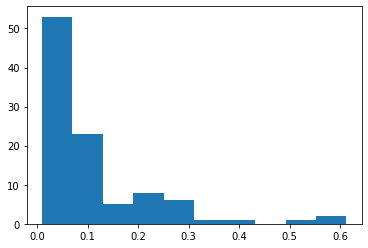

In [21]:
plt.hist(B_err)

(array([70., 18.,  6.,  1.,  0.,  1.,  1.,  1.,  0.,  2.]),
 array([4.77551472e-05, 5.19969122e-03, 1.03516273e-02, 1.55035634e-02,
        2.06554994e-02, 2.58074355e-02, 3.09593716e-02, 3.61113076e-02,
        4.12632437e-02, 4.64151798e-02, 5.15671158e-02]),
 <a list of 10 Patch objects>)

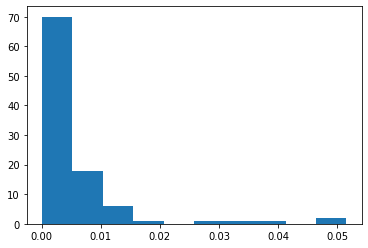

In [22]:
plt.hist(lamb_err)